# Contents
- [Data Setup](#Data-Setup)
- [Randomization Methods](#Randomization-Methods)
- [AA Testing](#AA-Testing)
    - [SRM Check](#SRM-Check)
- [Power Analysis](#Power-Analysis)
- [AB Testing](#AB-Testing)
- [Results](#Results)
    - [Summary](#Conversion-Rates)
    - [Visualization](#Visualization)
    - [Confidence Intervals Within Groups](#Confidence-Intervals-Outcomes)
    - [Confidence Intervals Across Groups](#Confidence-Intervals-Difference)
    - [Conclusion](#Conclusion)
- [How Long](#How-Long)
- [Post Hoc Analysis](#Post-Hoc-Analysis)
    - [Segmented Lift](#Segmented-Lift)
    - [Gaurdrail Metrics](#Gaurdrail-Metrics)
    - [Rollout Simulation](#Rollout-Simulation)
- [Other Notes](#Other-Notes)
    - [Experimentation-Infrastructure](#Experimentation-Infrastructure)
- [Scratch Notes](#Scratch-Notes)
    - [Other Use Cases](#Other-Use-Cases)

<details>
<summary><strong>🧪 A/B Test - Decision Flow (click to expand)</strong></summary>

```
[What is your outcome type?]  
   |  
   +--> Binary (e.g., converted = 1 or 0, clicked or not)  
   |     |  
   |     +--> What are you comparing?  
   |           |  
   |           +--> Proportions (e.g., 10% vs 12% conversion rate)  
   |           |     |  
   |           |     +--> Comparing 2 groups ---------> Use Z-test  
   |           |     |                                 Compares success rates (proportions) between 2 groups  
   |           |     +--> Comparing 3+ groups --------> Use Chi-Square Test  
   |           |                                       Tests whether at least one group’s success rate differs; follow with pairwise Z-tests  
   |           +--> Counts (e.g., number of users who converted)  
   |                 +--> Comparing 2 groups ---------> Use Chi-Square Test  
   |                 +--> Comparing 3+ groups --------> Use Chi-Square Test  
   |  
   +--> Continuous (e.g., revenue, time spent, items bought)  
   |     +--> Comparing 2 groups  
   |     |     +--> Are the groups made of different users?  
   |     |           +--> Yes  
   |     |           |     +--> Is the outcome roughly normal?  
   |     |           |           +--> Yes ------------> Use Independent T-test  
   |     |           |           +--> No -------------> Use Mann-Whitney U Test  
   |     |           +--> No (same users before/after)  
   |     |                 +--> Is the outcome roughly normal?  
   |     |                       +--> Yes ------------> Use Paired T-test  
   |     |                       +--> No -------------> Use Wilcoxon Signed-Rank Test  
   |     +--> Comparing 3+ groups --------------------> Use ANOVA  
   |  
   +--> Categorical (e.g., selected A/B/C option)  
         +--> Comparing 2 or more groups -------------> Use Chi-Square Test  

[Other Scenarios]  
   +--> Want to control for other variables? ---------> Use Regression (Linear or Logistic)  
   +--> Prefer probability over p-values? ------------> Use Bayesian A/B Testing  

</details>


<details> <summary><strong>📊 A/B Test - Decision Flow Flattened Table (click to expand) </strong></summary>
    
| Outcome Type | What Are You Comparing?          | Group Count | Group Structure | Outcome Distribution | Statistical Test        | What It Does                                             | Example Problem Statement |
|--------------|----------------------------------|-------------|------------------|-----------------------|--------------------------|----------------------------------------------------------|----------------------------|
| Binary        | Proportions (% converted)        | 2           | Independent      | N/A                   | Z-test                   | Compares proportions between 2 groups                    | Does the new homepage increase conversion from 10% to 12%? |
| Binary        | Proportions                      | 3+          | Independent      | N/A                   | Chi-Square               | Tests if at least one group’s conversion rate differs    | Is there a significant difference in conversion across blue/orange/green CTA? |
| Binary        | Counts (e.g., #converted users)  | 2           | Independent      | N/A                   | Chi-Square               | Compares success/failure counts between groups           | Did 120 out of 1000 in group A convert vs 150 out of 1000 in group B? |
| Binary        | Counts                           | 3+          | Independent      | N/A                   | Chi-Square               | Compares categorical counts across multiple groups       | Do different signup flows lead to different conversion counts? |
| Continuous    | Mean of a metric (e.g., revenue) | 2           | Independent      | Normal                | Independent T-test       | Compares average outcome across 2 independent groups     | Does average order value differ between control and treatment? |
| Continuous    | Mean of a metric                 | 2           | Independent      | Not normal            | Mann-Whitney U           | Compares ranks/distributions between 2 independent groups| Is time-on-site higher in treatment group (skewed data)? |
| Continuous    | Before vs After (same users)     | 2           | Paired           | Normal                | Paired T-test            | Compares mean change for same users before and after     | Did users spend more on their second visit after UI update? |
| Continuous    | Before vs After (same users)     | 2           | Paired           | Not normal            | Wilcoxon Signed-Rank     | Compares paired non-normal outcomes                      | Did session duration increase for the same users post-change? |
| Continuous    | Mean outcome                     | 3+          | Independent      | Any                   | ANOVA                    | Compares means across 3 or more groups                   | Does average basket size differ across A/B/C pricing variants? |
| Categorical   | User-selected categories         | 2+          | Independent      | N/A                   | Chi-Square               | Tests distribution of categories across groups           | Do users pick different plans (Basic, Pro, Premium) across test groups? |
| Any           | Adjusting for other variables    | Any         | Any              | N/A                   | Regression (Linear/Logistic) | Measures treatment effect while controlling for covariates | Is treatment still effective after accounting for device and region? |
| Any           | Prefer probability > p-value     | Any         | Any              | N/A                   | Bayesian A/B Test        | Returns probability one group is better than the other   | What’s the probability green button outperforms blue? |
| Binary (Paired) | Conversion before vs after (same users) | 2     | Paired           | N/A                   | McNemar’s Test           | Tests change in conversion for same users                | Did logged-in users convert more after design change? |  
</details>

<details> <summary><strong>📊 When to Use Which Statistical Test in A/B Testing </strong></summary>

#### 🧪 When to Use Which Statistical Test in A/B Testing

| **Metric Type**        | **Example**                        | **Recommended Test**                      | **Why**                                                  |
|------------------------|------------------------------------|-------------------------------------------|-----------------------------------------------------------|
| Continuous             | Revenue, time on site, scores      | `scipy.stats.ttest_ind` (T-test)          | Compares means of two independent groups                 |
| Continuous (unequal variance) | Same as above               | `ttest_ind(..., equal_var=False)`         | Welch’s T-test — safer when variances differ             |
| Binary (0/1 outcomes)  | Conversion, click, purchase        | `statsmodels.stats.proportions_ztest`     | Compares proportions between two groups                  |
| Count data             | # pageviews, # items bought        | Poisson or Negative Binomial test         | For skewed count distributions                           |
| Non-parametric         | Ordinal/skewed data, NPS scores    | Mann-Whitney U test                       | No assumption of normality                               |
| Multiple groups (A/B/C)| Multi-variant tests                | ANOVA (continuous), Chi-squared (binary)  | Tests across 3+ groups                                   |

---

#### ✅ Quick Rules of Thumb:
- If your metric is **continuous + normal-ish** → Use **T-test**
- If it’s **binary (e.g., clicked or not)** → Use **Z-test**
- If it’s **non-normal or skewed** → Use **Mann-Whitney U test**
- If testing **3 or more variants** → Use **ANOVA** or **Chi-squared**

</details>

# Data Setup

In [1]:
# Display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import (
    ttest_ind,
    ttest_rel,
    chi2_contingency,
    mannwhitneyu
)
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.power import (
    TTestIndPower,
    TTestPower,
    FTestAnovaPower,
    NormalIndPower
)

# Set Seed 
my_seed=42
np.random.seed(my_seed)

##### Test Parameters

In [2]:
experiment_type = 'binary' # options: 'binary', 'continuous_independent', 'continuous_paired', 'categorical'
# Options:
#   'binary'                 → Comparing proportions (e.g., conversion rate) between 2 groups — uses Z-test
#   'continuous_independent' → Comparing means of a continuous metric between 2 independent groups — uses T-test
#   'continuous_paired'      → Comparing means of a continuous metric within the same users (e.g., before vs after) — uses Paired T-test
#   'categorical'            → Comparing distribution of categorical outcomes across 2 groups — uses Chi-Square Test

group_labels = ('control', 'treatment')
# Tuple specifying the names of your control and treatment groups.
# Order matters — first is control, second is treatment. All logic assumes two groups.

outcome_metric_col = 'engagement_score'
# The main outcome variable you're analyzing. 
# Can be binary, continuous, or categorical depending on experiment_type.

segment_cols = ['platform', 'device_type', 'user_tier', 'region']
# List of columns to use for segmented post-hoc analysis.
# Will break down lift and statistical differences by each of these dimensions.

guardrail_metrics = ['bounce_rate']
# List of non-primary metrics (guardrails) you want to monitor for regressions.
# Guardrails help detect harm even if the primary metric improves.

randomization_method = 'simple'  
# Which method to use for assigning users to control vs treatment groups.
# Options: 'simple', 'stratified', 'block', 'matched_pair', 'cluster', 'cuped'

group_col = 'group'  
# Name of the column in your DataFrame where group assignments will be stored.
# Used throughout the pipeline for consistency.

##### Sample user data

In [3]:
observations_count = 1000

np.random.seed(my_seed) # For reproducibility
users = pd.DataFrame({
    'user_id': range(1, observations_count+1),
    'platform': np.random.choice(['iOS', 'Android'], size=observations_count, p=[0.6, 0.4]), # 60% iOS, 40% Android
    'engagement_score': np.random.normal(50, 15, observations_count), # Simulated user engagement scores
    'city': np.random.choice(['ny', 'sf', 'chicago', 'austin'], size=observations_count),
    'past_purchase_count': np.random.normal(loc=50, scale=10, size=observations_count) # pre_experiment_metric for CUPED randomization
})
users

,user_id,platform,engagement_score,city,past_purchase_count
0,1,iOS,52.665515,ny,34.018756
1,2,Android,29.969835,ny,54.621727
2,3,Android,55.702968,ny,70.243096
3,4,iOS,59.158786,ny,36.368260
4,5,iOS,58.396857,ny,51.897062
...,...,...,...,...,...
995,996,iOS,30.199662,sf,63.305749
996,997,Android,40.823464,chicago,38.032114
997,998,iOS,49.444448,chicago,58.936977
998,999,Android,43.560467,austin,58.929539


[Back to the top](#Contents)
___


# Randomization Methods

<details> <summary><strong>📊 Click to Expand </strong></summary>
Randomization is used to ensure that observed differences in outcome metrics are due to the experiment, not pre-existing differences.

- Prevents **selection bias** (e.g., users self-selecting into groups)  
- Balances **confounding factors** like platform, region, or past behavior  
- Enables **valid inference** through statistical testing
</details>

### 🎯 Simple Randomization 

<details> <summary><strong>📊 Click to Expand </strong></summary>
Each user is assigned to control or treatment with **equal probability**, independent of any characteristics.

##### When to Use
- Sample size is **large enough** to ensure natural balance  
- No strong concern about **confounding variables**  
- Need a **quick, default assignment** strategy

##### How It Works
- Assign each user randomly (e.g., 50/50 split)  
- No grouping, segmentation, or blocking involved  
- Groups are expected to balance out on average  
</details>

In [4]:
def apply_simple_randomization(df, group_labels=('control', 'treatment'), group_col='group', seed=my_seed):
    """
    Randomly assigns each row to one of the specified groups.

    Parameters:
    - df: pandas DataFrame containing observations
    - group_labels: tuple of group names (default = ('control', 'treatment'))
    - group_col: name of the column to store group assignments
    - seed: random seed for reproducibility

    Returns:
    - DataFrame with an added group assignment column
    """
    np.random.seed(seed)
    df[group_col] = np.random.choice(group_labels, size=len(df), replace=True)
    return df

### Stratified Sampling  


<details> <summary><strong>📊 Click to Expand </strong></summary>
Ensures that key segments (e.g., platform, region) are evenly represented across control and treatment.

##### When to Use
- User base is **naturally skewed** (e.g., 70% mobile, 30% desktop)  
- Important to control for **known confounders** like geography or device  
- You want balance **within subgroups**, not just overall

##### How It Works
- Pick a stratification variable (e.g., platform)  
- Split population into strata (groups)  
- Randomly assign users **within each stratum**  
</details>


In [5]:
def apply_stratified_randomization(df, stratify_col, group_labels=('control', 'treatment'), group_col='group', seed=my_seed):
    """
    Performs stratified randomization to assign rows into multiple groups while maintaining balance across strata.

    Parameters:
    - df: pandas DataFrame to assign groups to
    - stratify_col: column to balance across (e.g., platform, region)
    - group_labels: list or tuple of group names
    - group_col: name of the column to store group assignments
    - seed: random seed for reproducibility

    Returns:
    - DataFrame with a new group assignment column
    """
    np.random.seed(seed)
    df = df.copy()
    df[group_col] = None
    n_groups = len(group_labels)

    # Stratify and assign
    for stratum_value, stratum_df in df.groupby(stratify_col):
        shuffled = stratum_df.sample(frac=1, random_state=seed)
        group_assignments = np.tile(group_labels, int(np.ceil(len(shuffled) / n_groups)))[:len(shuffled)]
        df.loc[shuffled.index, group_col] = group_assignments

    return df

### Block Randomization  
<details> <summary><strong>📊 Click to Expand </strong></summary>
Groups users into fixed-size blocks and randomly assigns groups within each block.

##### When to Use
- Users arrive in **time-based batches** (e.g., daily cohorts)  
- Sample size is **small** and needs enforced balance  
- You want to minimize **temporal or ordering effects**

##### How It Works
- Create blocks based on order or ID (e.g., every 10 users)  
- Randomize assignments **within each block**  
- Ensures near-equal split in every batch  
</details>


In [6]:
def apply_block_randomization(
    df,
    observation_id_col='user_id',
    group_col='group',
    block_size=10,
    group_labels=('control', 'treatment'),
    seed=42
):
    """
    Assigns group labels using block randomization to ensure balance within fixed-size blocks.

    Parameters:
    - df: DataFrame to assign groups
    - observation_id_col: Unique ID to sort and block on (e.g., user_id)
    - group_col: Name of column to store assigned group labels
    - block_size: Number of observations in each block
    - group_labels: Tuple or list of group names (e.g., ('control', 'treatment', 'variant_B'))
    - seed: Random seed for reproducibility

    Returns:
    - DataFrame with a new column [group_col] indicating assigned group
    """
    np.random.seed(seed)
    df = df.sort_values(observation_id_col).reset_index(drop=True).copy()
    n_groups = len(group_labels)

    # Create block ID per row
    df['_block'] = df.index // block_size

    # Assign groups within each block
    group_assignments = []
    for _, block_df in df.groupby('_block'):
        block_n = len(block_df)
        reps = int(np.ceil(block_n / n_groups))
        candidates = np.tile(group_labels, reps)[:block_n]
        np.random.shuffle(candidates)
        group_assignments.extend(candidates)

    df[group_col] = group_assignments
    df = df.drop(columns=['_block'])

    return df

### Match Pair Randomization

<details> <summary><strong>📊 Click to Expand </strong></summary>
Participants are **paired based on similar characteristics** before random group assignment.  
This reduces variance and improves **statistical power** by ensuring balance on key covariates.

##### When to Use
- Small sample size with high risk of **confounding**
- Outcomes influenced by user traits (e.g., **age, income, tenure**)  
- Need to **minimize variance** across groups

##### How It Works
1. Identify important covariates (e.g., age, purchase history)  
2. Sort users by those variables  
3. Create matched pairs (or small groups)  
4. Randomly assign one to **control**, the other to **treatment**  
</details>


In [7]:
def apply_matched_pair_randomization(
    df,
    sort_col,
    group_col='group',
    group_labels=('control', 'treatment')
):
    """
    Assigns groups using matched-pair randomization based on a sorting variable.

    Parameters:
    - df: pandas DataFrame to assign groups to
    - sort_col: column used to sort users before pairing (e.g., engagement score)
    - group_col: name of the column to store group assignments
    - group_labels: tuple of group names (e.g., ('control', 'treatment'))

    Returns:
    - DataFrame with alternating group assignments within sorted pairs
    """
    # Sort by matching variable so similar users are adjacent
    df = df.sort_values(by=sort_col).reset_index(drop=True)

    # Cycle through group labels for each row
    df[group_col] = [group_labels[i % len(group_labels)] for i in range(len(df))]

    return df


### Cluster Randomization
<details> <summary><strong>📊 Click to Expand </strong></summary>
Entire **groups or clusters** (e.g., cities, stores, schools) are assigned to control or treatment.  
Used when it's impractical or risky to randomize individuals within a cluster.

###### When to Use
- Users naturally exist in **groups** (e.g., teams, locations, devices)
- There's a risk of **interference** between users (e.g., word-of-mouth)
- Operational or tech constraints prevent individual-level randomization

###### How It Works
1. Define the cluster unit (e.g., store, city)  
2. Randomly assign each cluster to control or treatment  
3. All users within the cluster inherit the group assignment  
</details>


In [8]:
def apply_cluster_randomization(
    df,
    cluster_col,
    group_col='group',
    group_labels=('control', 'treatment'),
    seed=my_seed
):
    """
    Assigns groups using cluster-level randomization — all observations in a cluster
    receive the same group assignment.

    Parameters:
    - df: pandas DataFrame to assign groups to
    - cluster_col: column representing the cluster unit (e.g., city, store)
    - group_col: name of the column where group labels will be stored
    - group_labels: tuple of group names to randomly assign (e.g., ('control', 'treatment'))
    - seed: random seed for reproducibility

    Returns:
    - DataFrame with assigned groups at the cluster level
    """
    np.random.seed(seed)

    # Unique clusters (e.g., unique city/store values)
    unique_clusters = df[cluster_col].unique()

    # Randomly assign each cluster to a group
    cluster_assignments = dict(
        zip(unique_clusters, np.random.choice(group_labels, size=len(unique_clusters)))
    )

    # Map group assignments to full DataFrame
    df[group_col] = df[cluster_col].map(cluster_assignments)

    return df

### CUPED (Controlled Pre-Experiment Data)
<details> <summary><strong>📊 Click to Expand </strong></summary>
A statistical adjustment that uses **pre-experiment behavior** to reduce variance and improve power.  
It helps detect smaller effects without increasing sample size.

##### When to Use
- You have reliable **pre-experiment metrics** (e.g., past spend, engagement)
- You want to **reduce variance** and improve test sensitivity
- You’re dealing with **small lifts** or **costly sample sizes**

##### How It Works
1. Identify a pre-period metric **correlated with your outcome**
2. Use regression to compute an adjustment (theta)  
3. Subtract the correlated component from your outcome metric  
4. Analyze the adjusted metric instead of the raw one  
</details>


In [9]:
import numpy as np
import statsmodels.api as sm

def apply_cuped(
    df,
    pre_metric,
    group_col='group',
    outcome_col='adjusted_outcome',
    group_labels=('control', 'treatment'),
    seed=my_seed
):
    """
    Applies CUPED (Controlled Pre-Experiment Data) adjustment to reduce variance
    using a pre-experiment covariate.

    Parameters:
    - df: pandas DataFrame with observations
    - pre_metric: column name of the pre-experiment covariate
    - group_col: column to store group assignments (default = 'group')
    - outcome_col: column to store CUPED-adjusted outcome
    - group_labels: tuple of group names (default = ('control', 'treatment'))
    - seed: random seed for reproducibility

    Returns:
    - DataFrame with randomized groups and CUPED-adjusted outcome metric
    """
    np.random.seed(seed)

    # Step 1: Random assignment if not already done
    df = df.copy()
    df = apply_simple_randomization(df, group_col=group_col, seed=seed)

    # Step 2: Simulate experiment outcome (replace this with actual outcome in production)
    y = np.random.normal(loc=0, scale=5, size=len(df))

    # Step 3: Estimate correction factor theta from pre-metric
    X = sm.add_constant(df[[pre_metric]])
    theta = sm.OLS(y, X).fit().params[pre_metric]

    # Step 4: Apply CUPED adjustment
    df[outcome_col] = y - theta * df[pre_metric]

    return df

In [10]:
# Mapping of method name to function call
method_map = {
    "simple": lambda df: apply_simple_randomization(df, group_col=group_col, seed=my_seed),
    "stratified": lambda df: apply_stratified_randomization(df, stratify_col='platform', group_col=group_col, seed=my_seed),
    "block": lambda df: apply_block_randomization(df, observation_id_col='user_id', group_col=group_col, block_size=10, seed=my_seed),
    "matched_pair": lambda df: apply_matched_pair_randomization(df, sort_col='engagement_score', group_col=group_col, seed=my_seed),
    "cluster": lambda df: apply_cluster_randomization(df, cluster_col='city', group_col=group_col, seed=my_seed),
    "cuped": lambda df: apply_cuped(df, pre_metric='past_purchase_count', group_col=group_col, group_labels=group_labels, seed=my_seed),
}

# Safety check
if randomization_method not in method_map:
    raise ValueError(f"❌ Unsupported randomization method: {randomization_method}")

# Apply selected method
users = method_map[randomization_method](users)
users


,user_id,platform,engagement_score,city,past_purchase_count,group
0,1,iOS,52.665515,ny,34.018756,control
1,2,Android,29.969835,ny,54.621727,treatment
2,3,Android,55.702968,ny,70.243096,control
3,4,iOS,59.158786,ny,36.368260,control
4,5,iOS,58.396857,ny,51.897062,control
...,...,...,...,...,...,...
995,996,iOS,30.199662,sf,63.305749,control
996,997,Android,40.823464,chicago,38.032114,control
997,998,iOS,49.444448,chicago,58.936977,treatment
998,999,Android,43.560467,austin,58.929539,treatment


[Back to the top](#Contents)
___


# AA Testing

<details> <summary><strong>📊 Click to Expand </strong></summary>

A/A testing is a **preliminary experiment** where both groups (e.g., “control” and “treatment”) receive the exact same experience. It's used to validate the experimental setup before running an actual A/B test.

##### What Are We Checking?
- Are users being assigned fairly and randomly?
- Are key outcome metrics statistically similar across groups?
- Can we trust the experimental framework?

##### Why A/A Testing Matters
- **Validates Randomization**  
  Confirms the groups are balanced at baseline (no bias or leakage)
  
- **Detects SRM (Sample Ratio Mismatch)**  
  Ensures the actual split (e.g., 50/50) matches what was intended
  
- **Estimates Variability**  
  Helps calibrate variance for accurate power calculations later
  
- **Trust Check**  
  Catches bugs in assignment logic, event tracking, or instrumentation

##### A/A Test Process

1. **Randomly assign users** into two equal groups  
   Just like you would for an A/B test (e.g., control vs treatment)

2. **Measure key outcome**  
   This depends on your experiment type:  
   - `binary` → conversion rate  
   - `continuous` → avg. revenue, time spent  
   - `categorical` → feature adoption, plan selected

3. **Run statistical test**  
   - `binary` → Z-test or Chi-square  
   - `continuous` → t-test  
   - `categorical` → Chi-square test

4. **Check SRM**  
   Use a chi-square goodness-of-fit test to detect assignment imbalances

##### Possible Outcomes
| Result                            | Interpretation                                     |
|-----------------------------------|----------------------------------------------------|
| No significant difference         | ✅ Randomization looks good. Test setup is sound.  |
| Statistically significant difference | ⚠️ Something’s off — check assignment logic, instrumentation, or sample leakage |

*Run A/A tests whenever you launch a new experiment framework, roll out a new randomizer, or need to build stakeholder trust.*

</details>

##### SRM Check 


<details> <summary><strong>📊 Click to Expand </strong></summary>
Is group assignment balanced?
- SRM (Sample Ratio Mismatch) checks whether the observed group sizes match the expected ratio.
- In a perfect world, random assignment to 'A1' and 'A2' should give ~50/50 split.
- SRM helps catch bugs in randomization, data logging, or user eligibility filtering.

##### Real-World Experiment Split Ratios
| **Scenario**                     | **Split**              | **Why**                                 |
|----------------------------------|------------------------|------------------------------------------|
| Default A/B                      | 50 / 50                | Maximizes power and ensures fairness     |
| Risky feature                    | 10 / 90 or 20 / 80     | Limits user exposure to minimize risk    |
| Ramp-up                          | Step-wise (1-5-25-50…) | Gradual rollout to catch issues early    |
| A/B/C Test                       | 33 / 33 / 33 or weighted | Compare multiple variants fairly or with bias |
| High control confidence needed   | 70 / 30 or 60 / 40     | More stability in baseline comparisons   |
</details>

In [11]:
def check_sample_ratio_mismatch(df, group_col, group_labels, expected_ratios=None, alpha=0.05):
    """
    Checks for Sample Ratio Mismatch (SRM) using Chi-Square test.

    Parameters:
    - df : pd.DataFrame
        The dataset containing group assignments.
    - group_col : str
        Column name where group assignment is stored.
    - group_labels : list or tuple
        List of group labels (e.g., ['control', 'treatment'])
    - expected_ratios : list or tuple
        Expected traffic allocation ratios per group (must match order in group_labels).
        If None, assumes equal allocation to all groups.
    - alpha : float
        Significance level for SRM detection.

    Returns:
    - None (prints results)
    """
    print("🔍 Sample Ratio Mismatch (SRM) Check")

    observed_counts = df[group_col].value_counts().reindex(group_labels, fill_value=0)

    if expected_ratios is None:
        expected_ratios = [1 / len(group_labels)] * len(group_labels)
    else:
        total = sum(expected_ratios)
        expected_ratios = [r / total for r in expected_ratios]  # Normalize to sum to 1

    expected_counts = [len(df) * ratio for ratio in expected_ratios]

    # Print group breakdown
    for grp, expected in zip(group_labels, expected_counts):
        observed = observed_counts.get(grp, 0)
        pct = observed / len(df) * 100
        print(f"Group {grp}: {observed} users ({pct:.2f}%) — Expected: {expected:.1f}")

    # Chi-square test
    chi2_stat, chi2_p = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)
    print(f"\nChi2 Statistic: {chi2_stat:.4f}")
    print(f"P-value       : {chi2_p:.4f}")
    if chi2_p < alpha:
        print("⚠️ SRM Detected — investigate group assignment.\n")
    else:
        print("✅ No SRM — group sizes look balanced.\n")

In [12]:
def run_outcome_similarity_test(df, group_col, metric_col, experiment_type, group_labels, alpha=0.05):
    """
    Runs outcome similarity test between two groups based on experiment_type.
    Returns p-value and prints human-readable interpretation.

    Parameters:
    - df: pandas DataFrame
    - group_col: column name representing group assignment
    - metric_col: column name of the outcome metric
    - experiment_type: one of ['binary', 'continuous_independent', 'continuous_paired', 'categorical']
    - group_labels: tuple of (control_group_name, treatment_group_name)
    - alpha: significance level (default 0.05)

    Returns:
    - p-value (float)
    """

    print("📏 Outcome Similarity Check\n")

    # Subset values
    group1_data = df[df[group_col] == group_labels[0]][metric_col]
    group2_data = df[df[group_col] == group_labels[1]][metric_col]

    if experiment_type == 'binary':
        conv1, conv2 = group1_data.mean(), group2_data.mean()
        n1, n2 = len(group1_data), len(group2_data)
        pooled_prob = (group1_data.sum() + group2_data.sum()) / (n1 + n2)
        se = np.sqrt(pooled_prob * (1 - pooled_prob) * (1/n1 + 1/n2))
        z_score = (conv2 - conv1) / se
        p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
        test_name = "z-test for proportions"

        print(f"Conversion Rate — {group_labels[0]}: {conv1:.4f}, {group_labels[1]}: {conv2:.4f}")
        print(f"Z-score: {z_score:.4f}")
        print(f"P-value: {p_value:.4f}")

    elif experiment_type == 'continuous_independent':
        t_stat, p_value = stats.ttest_ind(group1_data, group2_data, equal_var=False)
        test_name = "independent t-test"
        print(f"T-statistic: {t_stat:.4f}")
        print(f"P-value    : {p_value:.4f}")

    elif experiment_type == 'continuous_paired':
        if len(group1_data) != len(group2_data):
            print("❌ Paired t-test requires equal number of observations in each group.")
            return None
        t_stat, p_value = stats.ttest_rel(group1_data, group2_data)
        test_name = "paired t-test"
        print(f"Paired T-statistic: {t_stat:.4f}")
        print(f"P-value           : {p_value:.4f}")

    elif experiment_type == 'categorical':
        contingency = pd.crosstab(df[group_col], df[metric_col])
        chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency)
        test_name = "chi-square test"
        print("Chi-square test on categorical outcome")
        print(f"Chi2-statistic: {chi2_stat:.4f}")
        print(f"P-value       : {p_value:.4f}")

    else:
        print(f"❌ Unsupported experiment_type: {experiment_type}")
        return None

    # ---------------- Interpretation ----------------
    print("\n🧠 Interpretation:")
    if experiment_type == 'binary':
        print(f"Used a {test_name} to compare conversion rates between groups.")
        print("Null Hypothesis: conversion rates are the same.")
    elif experiment_type.startswith('continuous'):
        print(f"Used a {test_name} to compare means of '{metric_col}' across groups.")
        print("Null Hypothesis: population means are equal.")
    elif experiment_type == 'categorical':
        print(f"Used a {test_name} to test whether '{metric_col}' distribution depends on group.")
        print("Null Hypothesis: no association between group and category.")

    print(f"\nWe use α = {alpha:.2f}")
    if p_value < alpha:
        print(f"➡️ p = {p_value:.4f} < α → Reject null hypothesis. Statistically significant difference.")
    else:
        print(f"➡️ p = {p_value:.4f} ≥ α → Fail to reject null. No statistically significant difference.")

    return p_value


In [13]:
def visualize_aa_distribution(
    df,
    group1,
    group2,
    group_col,
    metric_col,
    experiment_type,
    group_labels=('control', 'treatment')
):
    """
    Visualizes A/A test outcome distributions based on experiment type.

    Parameters:
    - df: Original DataFrame (needed for categorical visual)
    - group1, group2: Series of metric values for each group
    - group_col: Name of the group assignment column
    - metric_col: Name of the metric/outcome column
    - experiment_type: 'binary', 'continuous_independent', 'continuous_paired', or 'categorical'
    - group_labels: Tuple of group names (default: ('control', 'treatment'))
    """
    if experiment_type.startswith('continuous'):
        plt.hist(group1, bins=30, alpha=0.5, label=group_labels[0])
        plt.hist(group2, bins=30, alpha=0.5, label=group_labels[1])
        plt.title(f'A/A Test: {metric_col} Distribution')
        plt.xlabel(metric_col)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show();

    elif experiment_type == 'binary':
        rates = [group1.mean(), group2.mean()]
        plt.bar(group_labels, rates)
        for i, rate in enumerate(rates):
            plt.text(i, rate + 0.01, f"{rate:.2%}", ha='center')
        plt.title(f'A/A Test: Conversion Rate by Group')
        plt.ylabel('Conversion Rate')
        plt.ylim(0, 1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show();

    elif experiment_type == 'categorical':
        contingency = pd.crosstab(df[group_col], df[metric_col], normalize='index')
        contingency.plot(kind='bar', stacked=True)
        plt.title(f'A/A Test: Distribution of {metric_col} by Group')
        plt.ylabel('Proportion')
        plt.xlabel(group_col)
        plt.legend(title=metric_col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show();

In [16]:
def run_aa_testing_generalized(
    df,
    group_col='group',
    metric_col='engagement_score',
    group_labels=('control', 'treatment'),
    experiment_type='continuous_independent',
    alpha=0.05,
    visualize=True
):
    """
    Runs a generalized A/A test including SRM check, statistical test, and optional visualization.

    Parameters:
    - df: Input DataFrame
    - group_col: Column specifying group assignment
    - metric_col: Metric to test (e.g., conversion rate, engagement score)
    - group_labels: Tuple of (control, treatment) group names
    - experiment_type: 'binary', 'continuous_independent', 'continuous_paired', or 'categorical'
    - alpha: Significance level
    - visualize: Whether to show distribution plots
    """
    print(f"\n📊 A/A Test Summary for metric: '{metric_col}' [{experiment_type}]\n")

    check_sample_ratio_mismatch(df, group_col, group_labels, alpha=alpha, expected_ratios=[0.5, 0.5])

    group1 = df[df[group_col] == group_labels[0]][metric_col]
    group2 = df[df[group_col] == group_labels[1]][metric_col]

    p_value = run_outcome_similarity_test(
        df=df,
        group_col=group_col,
        metric_col=metric_col,
        experiment_type=experiment_type,
        group_labels=group_labels,
        alpha=alpha
    )

    if visualize and p_value is not None:
        visualize_aa_distribution(
            df, group1, group2,
            group_col=group_col,
            metric_col=metric_col,
            experiment_type=experiment_type,
            group_labels=group_labels
        )



📊 A/A Test Summary for metric: 'engagement_score' [continuous_independent]

🔍 Sample Ratio Mismatch (SRM) Check
Group control: 490 users (49.00%) — Expected: 500.0
Group treatment: 510 users (51.00%) — Expected: 500.0

Chi2 Statistic: 0.4000
P-value       : 0.5271
✅ No SRM — group sizes look balanced.

📏 Outcome Similarity Check

T-statistic: -1.1154
P-value    : 0.2649

🧠 Interpretation:
Used a independent t-test to compare means of 'engagement_score' across groups.
Null Hypothesis: population means are equal.

We use α = 0.05
➡️ p = 0.2649 ≥ α → Fail to reject null. No statistically significant difference.


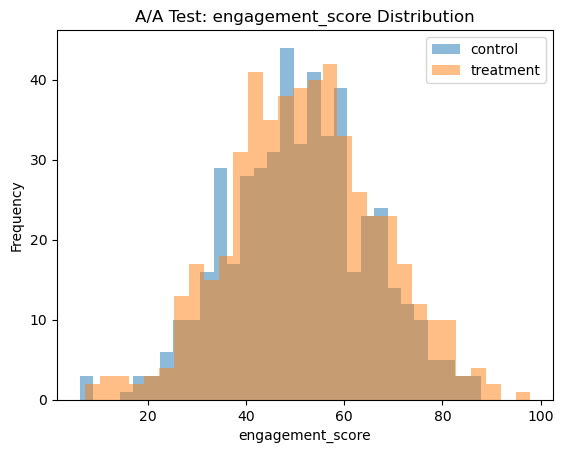

In [17]:
# For continuous metric like engagement_score
run_aa_testing_generalized(users, group_col='group', metric_col='engagement_score', experiment_type='continuous_independent')

# For binary outcome like converted (0/1)
# run_aa_testing_generalized(users, group_col='group', metric_col='converted', experiment_type='binary')

# For paired before/after measurements
# run_aa_testing_generalized(pre_post_df, group_col='group', metric_col='time_spent', experiment_type='continuous_paired')

# For categorical outcomes (e.g., plan type)
# run_aa_testing_generalized(users, group_col='group', metric_col='plan_type', experiment_type='categorical')

[Back to the top](#Contents)
___


# Power Analysis

<details> <summary><strong>📊 Click to Expand </strong></summary>
Power analysis helps determine the **minimum sample size** required to detect a true effect with statistical confidence.

##### Why It Matters:
- Avoids **underpowered tests** (risk of missing real effects)
- Balances tradeoffs between Sample size, Minimum Detectable Effect (MDE), Significance level (α), Statistical power (1 - β)

##### Key Inputs:
| Parameter      | Meaning                                                   |
|----------------|------------------------------------------------------------|
| **alpha (α)**  | Significance level (probability of false positive), e.g. 0.05 |
| **Power (1 - β)** | Probability of detecting a true effect, e.g. 0.80 or 0.90 |
| **Baseline**   | Current outcome (e.g., 10% conversion, $50 revenue)         |
| **MDE**        | Minimum detectable effect — the smallest meaningful lift (e.g., +2% or +$5) |
| **Std Dev**    | Standard deviation of the metric (for continuous outcomes) |
| **Effect Size**| Optional: Cohen's d (for t-tests) or f (for ANOVA)         |
| **Groups**     | Number of groups (relevant for ANOVA)                      |

This notebook automatically selects the correct formula based on `experiment_type` variable.

</details>


In [ ]:
def calculate_power_sample_size(
    experiment_type,
    alpha=0.05,
    power=0.80,
    baseline_rate=None, # For binary: e.g., 0.10 = 10% conversion rate
    mde=None,           # Minimum Detectable Effect (absolute change)
                        # e.g., 0.02 for 2% lift in binary, or $5 increase in continuous
    std_dev=None,       # Std deviation of outcome for continuous outcomes
    effect_size=None,   # Cohen's d (for t-tests) or w (for chi-square)
    num_groups=2        # Only relevant for ANOVA (if ever extended)
):
    """
    Generalized sample size calculator for A/B testing based on experiment type.

    Parameters
    ----------
    experiment_type : str
        One of:
        - 'binary'                 : Binary outcome (Z-test on proportions)
        - 'continuous_independent' : Continuous outcome, different users (independent t-test)
        - 'continuous_paired'      : Continuous outcome, same users (paired t-test)
        - 'categorical'            : Categorical outcome (Chi-square test)

    alpha : float
        Significance level (Type I error), usually 0.05

    power : float
        Desired power of the test, e.g., 0.80 for 80%

    baseline_rate : float
        Required for binary test — e.g., 0.10 for 10% conversion rate

    mde : float
        Minimum detectable effect (absolute lift):
        - Binary: 0.02 → detect +2% lift
        - Continuous: 5 → detect $5 difference

    std_dev : float
        Required for continuous outcome tests (if effect_size not provided)

    effect_size : float
        Optional: Cohen’s d (t-tests) or Cohen’s w (Chi-square)

    num_groups : int
        Reserved for ANOVA extensions; not used in current version.

    Returns
    -------
    int
        Required sample size per group
    """

    # ----- 1. Binary Outcome -----
    if experiment_type == 'binary':
        if baseline_rate is None or mde is None:
            raise ValueError("baseline_rate and mde are required for binary tests.")
        
        z_alpha = stats.norm.ppf(1 - alpha / 2)
        z_beta = stats.norm.ppf(power)
        p1 = baseline_rate
        p2 = p1 + mde
        pooled_std = np.sqrt(2 * p1 * (1 - p1))

        n = ((z_alpha + z_beta) ** 2 * pooled_std ** 2) / (mde ** 2)
        return int(np.ceil(n))

    # ----- 2. Continuous (Independent Groups) -----
    elif experiment_type == 'continuous_independent':
        if std_dev is None and effect_size is None:
            raise ValueError("Provide std_dev or effect_size for continuous_independent test.")
        if effect_size is None:
            effect_size = mde / std_dev
        
        analysis = TTestIndPower()
        n = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha)
        return int(np.ceil(n))

    # ----- 3. Continuous (Paired Users) -----
    elif experiment_type == 'continuous_paired':
        if std_dev is None and effect_size is None:
            raise ValueError("Provide std_dev or effect_size for continuous_paired test.")
        if effect_size is None:
            effect_size = mde / std_dev

        analysis = TTestPower()
        n = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha)
        return int(np.ceil(n))

    # ----- 4. Categorical Outcome (Chi-square) -----
    elif experiment_type == 'categorical':
        if effect_size is None:
            raise ValueError("effect_size (Cohen's w) is required for categorical tests.")
        
        analysis = NormalIndPower()  # Approximate method
        n = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha)
        return int(np.ceil(n))

    else:
        raise ValueError(f"Unsupported experiment_type: {experiment_type}")


In [ ]:
# 🎯 Experiment assumptions
experiment_type = 'binary'   # Options: 'binary', 'continuous_independent', 'continuous_paired', 'categorical'
alpha = 0.05                 # Type I error tolerance (false positive rate)
power = 0.80                 # 1 - β (probability of detecting a true effect)
baseline_rate = 0.10         # For binary: current conversion rate = 10%
mde = 0.02                   # Minimum detectable effect (e.g., +2% lift or +$5 increase)
std_dev = None               # Required for continuous outcomes if effect_size is not provided
effect_size = None           # Optional: Cohen’s d (continuous) or w (categorical)
num_groups = None            # Not used currently; placeholder for future ANOVA extension

# 🧮 Sample size calculation
required_sample_size = calculate_power_sample_size(
    experiment_type=experiment_type,
    alpha=alpha,
    power=power,
    baseline_rate=baseline_rate,
    mde=mde,
    std_dev=std_dev,
    effect_size=effect_size,
    num_groups=num_groups
)

print(f"✅ Required sample size per group: {required_sample_size}")
print(f"👥 Total sample size (Control + Treatment): {required_sample_size * 2}")

In [ ]:
def print_power_analysis_summary(
    experiment_type,
    alpha,
    power,
    baseline_rate=None,
    mde=None,
    std_dev=None,
    effect_size=None,
    num_groups=None,
    required_sample_size=None
):
    print("📈 Power Analysis Summary")
    print(f"- Significance level (α): {alpha}")
    print(f"- Statistical power (1 - β): {power}")

    if experiment_type == 'binary':
        print(f"- Baseline conversion rate: {baseline_rate}")
        print(f"- Minimum detectable effect (MDE): {mde}")
        if baseline_rate is not None and mde is not None:
            print(f"- Target conversion rate: {baseline_rate + mde:.2f}")
        print(f"\n✅ Result:")
        print(f"To detect a lift from {baseline_rate:.2f} to {baseline_rate + mde:.2f},")
        print(f"you need {required_sample_size} users in each group (control and treatment).")
        print(f"Total sample size: {required_sample_size * 2} users.")

    elif experiment_type == 'continuous_independent':
        if std_dev:
            print(f"- Std Dev (between users): {std_dev}")
            print(f"- MDE (difference to detect): {mde}")
            print(f"- Effect size (Cohen's d): {mde / std_dev:.2f}")
        else:
            print(f"- Effect size (Cohen's d): {effect_size}")
        
        print(f"\n✅ Result:")
        print(f"To detect a mean difference of {mde} between two independent groups,")
        print(f"you need {required_sample_size} users per group (total {required_sample_size * 2}).")

    elif experiment_type == 'continuous_paired':
        if std_dev:
            print(f"- Std Dev (of within-user differences): {std_dev}")
            print(f"- MDE (within-user change): {mde}")
            print(f"- Effect size (Cohen's d): {mde / std_dev:.2f}")
        else:
            print(f"- Effect size (Cohen's d): {effect_size}")
        
        print(f"\n✅ Result:")
        print(f"To detect a mean change of {mde} within the same users,")
        print(f"you need data from {required_sample_size} users.")

    elif experiment_type == 'categorical':
        print(f"- Outcome type: Categorical")
        print(f"- Effect size (Cohen's w): {effect_size}")
        print(f"\n✅ Result:")
        print(f"To detect a significant difference in categorical outcome distribution between groups,")
        print(f"you need {required_sample_size} users per group (total {required_sample_size * 2}).")

    else:
        print("⚠️ Unknown experiment type — no summary printed.")


In [ ]:
print_power_analysis_summary(
    experiment_type=experiment_type,  # 'binary', 'continuous_independent', 'continuous_paired', or 'categorical'
    alpha=alpha,                      # e.g., 0.05
    power=power,                      # e.g., 0.80
    baseline_rate=baseline_rate,      # Required for 'binary'
    mde=mde,                          # Required for binary and continuous if effect_size is not used
    std_dev=std_dev,                  # For continuous types
    effect_size=effect_size,          # Optional override for t-test or chi-square
    num_groups=None,                  # Currently unused, keep as None
    required_sample_size=required_sample_size
)


[Back to the top](#Contents)
___

# AB Testing


<details> <summary><strong>📊 Click to Expand </strong></summary>

##### 🧪 A/B Testing - Outcome Comparison

This section compares the outcome metric between control and treatment groups using the appropriate statistical test based on the experiment type.

##### Metric Tracked:
- **Primary metric:** Depends on use case:
  - Binary: Conversion rate (clicked or not)
  - Continuous: Average engagement, revenue, time spent
  - Categorical: Plan type, user tier, etc.
- **Unit of analysis:** Unique user or unique observation

##### Outcome Analysis Steps:
- Choose the **right statistical test** based on `experiment_type`
  - `'binary'` → **Z-test for proportions**
  - `'continuous_independent'` → **Two-sample t-test**
  - `'continuous_paired'` → **Paired t-test**
  - `'categorical'` → **Chi-square test of independence**
- Calculate test statistics, p-values, and confidence intervals
- Visualize the comparison to aid interpretation

</details>

In [ ]:
def run_ab_test(
    df,
    group_col='group',
    metric_col='converted',
    experiment_type='binary',
    group_labels=('control', 'treatment'),
    alpha=0.05
):
    """
    Run A/B test and perform statistical test based on the experiment type.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the test data
    group_col : str
        Column indicating group assignment
    metric_col : str
        Column indicating outcome metric
    experiment_type : str
        Type of test: 'binary', 'continuous_independent', 'continuous_paired', or 'categorical'
    group_labels : tuple
        Tuple containing labels for control and treatment (default = ('control', 'treatment'))
    alpha : float
        Significance level (default = 0.05)

    Returns:
    --------
    dict
        Dictionary with summary statistics, test type, and test results
    """
    group1, group2 = group_labels
    data1 = df[df[group_col] == group1][metric_col]
    data2 = df[df[group_col] == group2][metric_col]

    result = {
        'experiment_type': experiment_type,
        'group_labels': group_labels,
        'alpha': alpha,
        'summary': {}
    }

    # --- Summary stats ---
    result['summary'][group1] = {
        'n': len(data1),
        'mean': data1.mean(),
        'std': data1.std() if experiment_type.startswith('continuous') else None,
        'sum': data1.sum() if experiment_type == 'binary' else None
    }
    result['summary'][group2] = {
        'n': len(data2),
        'mean': data2.mean(),
        'std': data2.std() if experiment_type.startswith('continuous') else None,
        'sum': data2.sum() if experiment_type == 'binary' else None
    }

    # --- Run appropriate test ---
    if experiment_type == 'binary':
        x1, n1 = data1.sum(), len(data1)
        x2, n2 = data2.sum(), len(data2)
        p_pooled = (x1 + x2) / (n1 + n2)
        se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))
        z_stat = (x2/n2 - x1/n1) / se
        p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
        result['test'] = 'z-test for proportions'
        result['z_stat'] = z_stat
        result['p_value'] = p_value

    elif experiment_type == 'continuous_independent':
        t_stat, p_value = stats.ttest_ind(data1, data2)
        result['test'] = 'independent t-test'
        result['t_stat'] = t_stat
        result['p_value'] = p_value

    elif experiment_type == 'continuous_paired':
        if len(data1) != len(data2):
            raise ValueError("Paired test requires equal-length groups with matching units.")
        t_stat, p_value = stats.ttest_rel(data1, data2)
        result['test'] = 'paired t-test'
        result['t_stat'] = t_stat
        result['p_value'] = p_value

    elif experiment_type == 'categorical':
        contingency = pd.crosstab(df[group_col], df[metric_col])
        chi2, p_value, _, _ = stats.chi2_contingency(contingency)
        result['test'] = 'chi-square test'
        result['chi2_stat'] = chi2
        result['p_value'] = p_value

    else:
        raise ValueError(f"Unsupported experiment_type: {experiment_type}")

    return result


In [ ]:
# ✅ Binary outcome: e.g., Conversion (0 or 1)
# result = run_ab_test(users, group_col='group', metric_col='converted', experiment_type='binary')
# result

# ✅ Continuous outcome, independent groups: e.g., Engagement score or revenue
result = run_ab_test(users, group_col='group', metric_col='engagement_score', experiment_type='continuous_independent')
result

# ✅ Continuous outcome, paired users: e.g., Before/after time spent
# result = run_ab_test(pre_post_df, group_col='group', metric_col='time_spent', experiment_type='continuous_paired')
# result

# ✅ Categorical outcome: e.g., plan_type (basic/premium/pro)
# result = run_ab_test(users, group_col='group', metric_col='plan_type', experiment_type='categorical')
# result

[Back to the top](#Contents)
___


# Results

#### Summarise Results

In [ ]:
def summarize_ab_test_result(result):
    """
    Prints statistical test results and summarizes group stats.
    No plots here — visualization handled separately.
    """

    exp_type = result['experiment_type']
    group1, group2 = result['group_labels']
    p_value = result.get('p_value')
    alpha = result.get('alpha', 0.05)

    print("\n" + "="*45)
    print(f"🧪 A/B Test Result Summary [{exp_type}]")
    print("="*45)

    # ---- Hypothesis Test Output ----
    print("\n📊 Hypothesis Test Result")
    print(f"Test used: {result.get('test', 'N/A')}")
    if 'z_stat' in result:
        print(f"Z-statistic: {result['z_stat']:.4f}")
    elif 't_stat' in result:
        print(f"T-statistic: {result['t_stat']:.4f}")
    elif 'chi2_stat' in result:
        print(f"Chi2-statistic: {result['chi2_stat']:.4f}")

    if p_value is not None:
        print(f"P-value    : {p_value:.4f}")
        print("✅ Statistically significant difference detected." if p_value < alpha else "🚫 No significant difference detected.")
    else:
        print("⚠️ P-value not found.")

    # ---- Summary Table ----
    print("\n📋 Group Summary:\n")
    display(pd.DataFrame(result['summary']).T)

    # ---- Lift Analysis (binary or continuous_independent) ----
    if exp_type in ['binary', 'continuous_independent']:
        group1_mean = result['summary'][group1]['mean']
        group2_mean = result['summary'][group2]['mean']
        lift = group2_mean - group1_mean
        pct_lift = lift / group1_mean if group1_mean else np.nan

        print("\n📈 Lift Analysis")
        print(f"- Absolute Lift   : {lift:.4f}")
        print(f"- Percentage Lift : {pct_lift:.2%}")

        try:
            n1 = result['summary'][group1]['n']
            n2 = result['summary'][group2]['n']

            if exp_type == 'binary':
                se = np.sqrt(group1_mean * (1 - group1_mean) / n1 + group2_mean * (1 - group2_mean) / n2)
            else:
                sd1 = result['summary'][group1].get('std')
                sd2 = result['summary'][group2].get('std')
                if sd1 is not None and sd2 is not None:
                    se = np.sqrt((sd1 ** 2) / n1 + (sd2 ** 2) / n2)
                else:
                    raise ValueError("Standard deviation missing for one or both groups.")

            z = 1.96
            ci_low = lift - z * se
            ci_high = lift + z * se
            print(f"- 95% CI for Lift : [{ci_low:.4f}, {ci_high:.4f}]")
        except Exception as e:
            print(f"⚠️ Could not compute confidence interval: {e}")

    print("="*45 + "\n")


In [ ]:
summarize_ab_test_result(result)

#### Visualization

In [ ]:
def plot_ab_test_results(result):
    """
    Generates visualization for A/B test results based on experiment type.
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    exp_type = result['experiment_type']
    group1, group2 = result['group_labels']

    print("\n📊 Visualization:")

    if exp_type in ['binary', 'continuous_independent', 'continuous_paired']:
        labels = [group1, group2]
        values = [result['summary'][group1]['mean'], result['summary'][group2]['mean']]
        plt.bar(labels, values, color=['gray', 'skyblue'])

        for i, val in enumerate(values):
            label = f"{val:.2%}" if exp_type == 'binary' else f"{val:.2f}"
            plt.text(i, val + 0.01, label, ha='center')

        ylabel = "Conversion Rate" if exp_type == 'binary' else "Average Value"
        plt.ylabel(ylabel);
        plt.title(f"{ylabel} by Group");
        plt.ylim(0, max(values) + 0.1 * max(values));
        plt.grid(axis='y', linestyle='--', alpha=0.6);
        plt.show();

    elif exp_type == 'categorical':
        dist = pd.DataFrame(result['summary'])
        dist.T.plot(kind='bar', stacked=True);
        plt.title(f"Categorical Distribution by Group");
        plt.ylabel("Proportion");
        plt.xlabel("Group");
        plt.grid(axis='y', linestyle='--', alpha=0.6);
        plt.show();


In [ ]:
plot_ab_test_results(result)

#### 95% Confidence Intervals (`outcome of groups`)

<details> <summary><strong>📊 Click to Expand </strong></summary>

- The 95% confidence interval gives a range in which we expect the **true conversion rate** to fall for each group.
- If the confidence intervals **do not overlap**, it's strong evidence that the difference is statistically significant.
- If they **do overlap**, it doesn't guarantee insignificance — you still need the p-value to decide — but it suggests caution when interpreting lift.

</details>

In [ ]:
def plot_confidence_intervals(result, z=1.96):
    """
    Plot 95% confidence intervals for group means (conversion rate or average outcome).
    
    Parameters:
    - result: dictionary returned by run_ab_test()
    - z: Z-score for confidence interval (default: 1.96 for 95%)
    """
    exp_type = result['experiment_type']
    group1, group2 = result['group_labels']
    summary = result['summary']
    
    if exp_type not in ['binary', 'continuous_independent', 'continuous_paired']:
        print(f"⚠️ Confidence interval plotting not supported for experiment_type: {exp_type}")
        return

    # Extract values
    p1 = summary[group1]['mean']
    p2 = summary[group2]['mean']
    n1 = summary[group1]['n']
    n2 = summary[group2]['n']

    if exp_type == 'binary':
        # Standard error for proportions
        se1 = np.sqrt(p1 * (1 - p1) / n1)
        se2 = np.sqrt(p2 * (1 - p2) / n2)
        ylabel = "Conversion Rate"
        title = "Conversion Rate with 95% Confidence Intervals"
    else:
        # Use std if available
        sd1 = summary[group1].get('std')
        sd2 = summary[group2].get('std')
        if sd1 is None or sd2 is None:
            print("⚠️ Standard deviation not available — cannot compute CI for continuous data.")
            return
        se1 = sd1 / np.sqrt(n1)
        se2 = sd2 / np.sqrt(n2)
        ylabel = "Mean Outcome"
        title = f"{ylabel} with 95% Confidence Intervals"

    # Confidence intervals
    ci1 = (p1 - z * se1, p1 + z * se1)
    ci2 = (p2 - z * se2, p2 + z * se2)

    # Plot
    plt.errorbar([group1, group2],
                 [p1, p2],
                 yerr=[[p1 - ci1[0], p2 - ci2[0]],
                       [ci1[1] - p1, ci2[1] - p2]],
                 fmt='o', capsize=10, color='black')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [ ]:
plot_confidence_intervals(result)


#### 95% Confidence Intervals (`difference in outcomes`). AKA `Lift Analysis`

<details> <summary><strong>📊 Click to Expand </strong></summary>
This confidence interval helps quantify uncertainty around the observed **lift** between treatment and control groups. It answers:

- *How large is the difference between groups?*
- *How confident are we in this lift estimate?*

We compute a 95% CI for the difference in means (or proportions), not just for each group. If this interval **does not include 0**, we can reasonably trust there's a true difference. If it **does include 0**, the observed difference might be due to random chance.

This complements the p-value — while p-values tell us if the difference is significant, **CIs tell us how big the effect is, and how uncertain we are.**
</details>


In [ ]:
def compute_lift_confidence_interval(result):
    """
    Computes and interprets the confidence interval for the difference in outcomes (lift)
    based on experiment type.

    Parameters:
    - result: dictionary returned by run_ab_test()

    Output:
    - Prints lift summary and 95% confidence interval (when applicable)
    """

    exp_type = result['experiment_type']
    group1, group2 = result['group_labels']
    alpha = result.get('alpha', 0.05)
    z = 1.96  # For 95% confidence

    print("\n" + "="*45)
    print(f"📈 95% CI for Difference in Outcome [{exp_type}]")
    print("="*45)

    if exp_type in ['binary', 'continuous_independent']:
        mean1 = result['summary'][group1]['mean']
        mean2 = result['summary'][group2]['mean']
        lift = mean2 - mean1
        n1 = result['summary'][group1]['n']
        n2 = result['summary'][group2]['n']

        if exp_type == 'binary':
            # SE for difference in proportions
            se_diff = np.sqrt(mean1 * (1 - mean1) / n1 + mean2 * (1 - mean2) / n2)
        else: # continuous_independent
            sd1 = result['summary'][group1].get('std')
            sd2 = result['summary'][group2].get('std')
            if sd1 is None or sd2 is None:
                print("⚠️ Standard deviation missing. Cannot compute CI.")
                return
            se_diff = np.sqrt((sd1 ** 2) / n1 + (sd2 ** 2) / n2)

        ci_low = lift - z * se_diff
        ci_high = lift + z * se_diff

        print(f"- Absolute Lift         : {lift:.4f}")
        print(f"- 95% Confidence Interval: [{ci_low:.4f}, {ci_high:.4f}]")

        if ci_low > 0:
            print("✅ We’re 95% confident the treatment improved the outcome.")
        elif ci_high < 0:
            print("🚫 We’re 95% confident the treatment worsened the outcome.")
        else:
            print("🤷 The CI includes 0 — result is not statistically significant.")

    elif exp_type == 'continuous_paired':
        print("- Paired t-test was used, which internally accounts for paired differences.")
        print("- The test already captures variance of differences directly.")
        print("- ✅ You may optionally compute CI using the standard error of the differences (not included here).")

    elif exp_type == 'categorical':
        print("- This test compares distributions across multiple categories (e.g., plan_type or country).")
        print("- There isn’t a single 'lift' value.")
        print("- To compute per-category lift and confidence intervals:")
        print("    → Get proportion of users in each category for control and treatment.")
        print("    → Compute difference (lift) for each category.")
        print("    → Use formula for difference in proportions to estimate CI for each.")
        print("⚠️ Placeholder: Categorical CI calculations not included yet.")

    else:
        print(f"⚠️ Unsupported experiment type: {exp_type}")

    print("="*45 + "\n")


In [ ]:
compute_lift_confidence_interval(result)


#### Final Conclusion

In [ ]:
def print_final_ab_test_summary(result):
    """
    Prints a final summary block for A/B test results based on experiment type.
    """
    exp_type = result['experiment_type']
    group1, group2 = result['group_labels']
    p_value = result.get('p_value')
    alpha = result.get('alpha', 0.05)
    
    print("="*40)
    print("          📊 FINAL A/B TEST SUMMARY")
    print("="*40)

    # For experiment types where group means are meaningful
    if exp_type in ['binary', 'continuous_independent']:
        mean1 = result['summary'][group1]['mean']
        mean2 = result['summary'][group2]['mean']
        lift = mean2 - mean1
        pct_lift = lift / mean1 if mean1 else np.nan

        label = "Conversion rate" if exp_type == 'binary' else "Avg outcome"
        test_name = result.get("test", "A/B test")

        print(f"👥  {group1.capitalize()} {label:<20}:  {mean1:.4f}")
        print(f"🧪  {group2.capitalize()} {label:<20}:  {mean2:.4f}")
        print(f"📈  Absolute lift              :  {lift:.4f}")
        print(f"📊  Percentage lift            :  {pct_lift:.2%}")
        print(f"🧪  P-value (from {test_name}) :  {p_value:.4f}")

    elif exp_type == 'continuous_paired':
        print("🧪 Paired T-Test was used to compare outcomes within the same users.")
        print(f"🧪 P-value: {p_value:.4f}")

    elif exp_type == 'categorical':
        print("🧪 Chi-square test was used to compare categorical distributions.")
        print(f"🧪 P-value: {p_value:.4f}")

    else:
        print("⚠️ Unknown experiment type.")

    print("-" * 40)

    # Verdict
    if p_value is not None:
        if p_value < alpha:
            print("✅ RESULT: Statistically significant difference detected.")
        else:
            print("❌ RESULT: No statistically significant difference detected.")
    else:
        print("⚠️ No p-value to determine significance.")

    print("="*40 + "\n")


In [ ]:
print_final_ab_test_summary(result)


[Back to the top](#Contents)
___


# How Long
##### to run the test?

<details> <summary><strong>📊 Click to Expand </strong></summary>
The duration of an A/B test depends on how quickly you reach the required sample size per group, as estimated during your power analysis.

##### ✅ Key Inputs
- Daily volume of eligible observations (users, sessions, or orders — depends on your unit of analysis)
- Required sample size per group (from power analysis)
- Traffic split ratio (e.g., 50/50, 10/90, 33/33/33)

##### 🧮 Formula

> Test Duration (in days) =  
> Required Sample Size per Group ÷ (Daily Eligible Observations × Group Split Proportion)

This ensures the experiment runs long enough to detect the expected effect with the desired confidence and power.

##### 💡 Planning Tips

1. Estimate required sample size using power analysis (based on effect size, baseline, alpha, and power)
2. Understand your traffic: 
   - What’s your average daily eligible traffic?
   - What unit of analysis is used (user, session, impression)?
3. Apply group split: 
   - e.g., for a 50/50 A/B test, each group gets 50% of traffic
4. Estimate days using the formula above.

##### 🧠 Real-World Considerations

- ✅ Ramp-Up Period  
  Gradually increase traffic exposure: 5% → 25% → 50% → full traffic.  
  Helps catch bugs, stability issues, and confounding edge cases early.

- ✅ Cool-Down Buffer  
  Avoid ending tests on weekends, holidays, or during unusual traffic spikes.  
  Add buffer days so your conclusions aren’t skewed by anomalies.

- ✅ Trust Checks Before Analysis  
  - A/A testing to verify setup  
  - SRM checks to confirm user distribution  
  - Monitor guardrail metrics (e.g., bounce rate, latency, load time)

##### 🗣️ Common Practitioner Advice
> “We calculate sample size using power analysis, then divide by daily traffic per group. But we always factor in buffer days — for ramp-up, trust checks, and stability. Better safe than sorry.”
> “Power analysis is the starting point. But we don’t blindly stop when we hit N. We monitor confidence intervals, metric stability, and coverage to make sure we’re making decisions the business can trust.”

</details>

In [ ]:
def estimate_test_duration(
    required_sample_size_per_group,
    daily_eligible_users,
    allocation_ratios=(0.5, 0.5), # e.g., 50/50 or (0.2, 0.8)
    buffer_days=2,
    experiment_type=None # optional, e.g., 'binary', 'categorical'
):
    """
    Estimate how long an A/B test will take based on sample size, traffic, and allocation split.

    Parameters:
    - required_sample_size_per_group: int
        Number of samples needed per group (from power analysis)
    - daily_eligible_users: int
        Total eligible observations (users/sessions/etc.) arriving per day
    - allocation_ratios: tuple
        Traffic proportion for each group (e.g., (0.5, 0.5) for A/B test)
    - buffer_days: int
        Additional buffer days for ramp-up, anomalies, etc.
    - experiment_type: str (optional)
        Metadata for reporting context (e.g., 'binary', 'continuous', 'categorical')

    Returns:
    - dict with per-group duration, max duration, and total estimated runtime
    """
    group_durations = []
    for alloc in allocation_ratios:
        users_per_day = daily_eligible_users * alloc
        days = required_sample_size_per_group / users_per_day if users_per_day else float('inf')
        group_durations.append(np.ceil(days))

    longest_group_runtime = int(max(group_durations))
    total_with_buffer = longest_group_runtime + buffer_days

    print("\n🧮 Estimated Test Duration")
    if experiment_type:
        print(f"- Experiment type           : {experiment_type}")
    print(f"- Required sample per group : {required_sample_size_per_group}")
    print(f"- Daily eligible traffic    : {daily_eligible_users}")
    print(f"- Allocation ratio (per group): {allocation_ratios}")
    print(f"- Longest group runtime     : {longest_group_runtime} days")
    print(f"- Buffer days (ramp-up etc.): {buffer_days}")
    print(f"✅ Total recommended runtime: {total_with_buffer} days\n")

    return {
        'experiment_type': experiment_type,
        'per_group_days': group_durations,
        'longest_group_runtime': longest_group_runtime,
        'recommended_total_duration': total_with_buffer
    }


<details>
<summary>🧭 Monitoring Dashboard</summary>

- **Overall Test Health**
  - Start/end date, traffic ramp-up %, time remaining  
  - SRM (Sample Ratio Mismatch) indicator  
  - P-value and effect size summary (updated daily)  

- **Primary Metric Tracking**
  - Daily trends for primary outcome (conversion, revenue, etc.)  
  - Cumulative lift + confidence intervals  
  - Statistical significance tracker (p-value, test stat)  

- **Guardrail Metrics**
  - Bounce rate, load time, checkout errors, etc.  
  - Alert thresholds (e.g., +10% increase in latency)  
  - Trend vs baseline and prior experiments  

- **Segment Drilldowns**
  - Platform (iOS vs Android), geography, user tier  
  - Detect heterogeneous treatment effects  
  - Option to toggle test results per segment  

- **Cohort Coverage**
  - Total users assigned vs eligible  
  - Daily inclusion and exclusion trends  
  - Debugging filters (e.g., why user X didn’t get assigned)  

- **Variance & Stability Checks**
  - Volatility of key metrics  
  - Pre vs post baseline comparisons  
  - Funnel conversion variance analysis  

- **Notes & Annotations**
  - Manual tagging of major incidents (e.g., bug fix deployed, pricing change)  
  - Timeline of changes affecting experiment interpretation  

</details>

[Back to the top](#Contents)
___


# Post Hoc Analysis

<details> <summary><strong>📊 Click to Expand </strong></summary>

> After statistical significance, post-hoc analysis helps **connect results to business confidence**.  
> It's not just *did it work* — but *how, for whom, and at what cost or benefit?*

##### 🧠 Why Post Hoc Analysis Matters
- Segments may **respond differently** — average lift may hide underperformance in subgroups  
- Guardrails may show **collateral damage** (e.g., slower load time, higher churn)  
- Stakeholders need **impact translation** — what does this mean in revenue, retention, or strategy?

##### 🔎 Typical Post Hoc Questions

- Segment Lift
  - Did certain platforms, geos, cohorts, or user types benefit more?
  - Any negative lift in high-value user segments?

- Guardrail Checks
  - Did the treatment impact non-primary metrics (e.g., latency, engagement, bounce rate)?
  - Were alert thresholds breached?

- Business Impact Simulation
  - How does the observed lift scale to 100% of eligible users?
  - What’s the projected change in conversions, revenue, or user satisfaction?

- Edge Case Discovery
  - Any bugs, instrumentation gaps, or unexpected usage patterns?
  - Did any user types get excluded disproportionately?

##### 📊 What to Report

| Area                  | What to Show                                                                 |
|-----------------------|------------------------------------------------------------------------------|
| Segment Analysis      | Table or chart showing lift per segment, sorted by effect size or risk      |
| Guardrail Metrics     | Summary table of guardrails vs baseline, with thresholds or annotations     |
| Revenue Simulation    | Projected uplift × traffic volume × conversion = business impact            |
| Confidence Range      | 95% CI for key metrics per segment (wherever possible)                      |
| Rollout Readiness     | Any blockers, mitigations, or next steps if full rollout is considered      |

##### 💡 Pro Tip  
Even if your p-value says “yes,” **business rollout is a risk-based decision**.  
Post-hoc analysis is where **statistical rigor meets product judgment**.

</details>

#### Segmented Lift

In [ ]:
np.random.seed(my_seed)  # for reproducibility

users['platform'] = np.random.choice(['iOS', 'Android'], size=len(users))
users['device_type'] = np.random.choice(['mobile', 'desktop'], size=len(users), p=[0.7, 0.3])
users['user_tier'] = np.random.choice(['new', 'returning'], size=len(users), p=[0.4, 0.6])
users['region'] = np.random.choice(['North', 'South', 'East', 'West'], size=len(users))

# Return a preview of the updated DataFrame
users.head()

In [ ]:
def visualize_segment_lift(df_segment, segment_col):
    """
    Visualizes lift per segment using a horizontal bar chart.
    """
    df_viz = df_segment.dropna(subset=['lift'])
    df_viz = df_viz.sort_values(by='lift', ascending=False)

    if df_viz.empty:
        print(f"⚠️ No lift data to visualize for '{segment_col}'\n")
        return

    plt.figure(figsize=(8, 0.4 * len(df_viz) + 2))
    bars = plt.barh(df_viz[segment_col], df_viz['lift'], color='skyblue')
    for bar, val in zip(bars, df_viz['lift']):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                 f"{val:.2f}", va='center', ha='left', fontsize=9)
    plt.axvline(0, color='gray', linestyle='--')
    plt.title(f"Lift from Control to Treatment by {segment_col}")
    plt.xlabel("Mean Difference (Treatment – Control)")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [ ]:
def analyze_segment_lift(
    df,
    group_col='group',
    metric_col='converted',
    segment_cols=['platform', 'device_type', 'user_tier', 'region'],
    group_labels=('control', 'treatment'),
    experiment_type='binary',
    min_count_per_group=30,
    visualize=True
):
    """
    Perform post-hoc segmented lift analysis for a given set of segments.

    Parameters:
    - df: DataFrame containing experiment results
    - group_col: Name of group column (e.g., 'group')
    - metric_col: Metric to compute lift on
    - segment_cols: List of columns to segment by
    - group_labels: Tuple of control and treatment group names
    - experiment_type: One of ['binary', 'continuous_independent', 'continuous_paired', 'categorical']
    - min_count_per_group: Minimum sample size per group to analyze segment
    - visualize: Whether to plot segmented lift
    """
    group1, group2 = group_labels

    for segment in segment_cols:
        print(f"\n🔎 Segmenting by: {segment}")
        seg_data = []

        for val in df[segment].dropna().unique():
            subset = df[df[segment] == val]
            g1 = subset[subset[group_col] == group1][metric_col]
            g2 = subset[subset[group_col] == group2][metric_col]

            if len(g1) < min_count_per_group or len(g2) < min_count_per_group:
                print(f"⚠️ Skipping segment '{val}' under '{segment}' — insufficient sample size.")
                continue

            lift = g2.mean() - g1.mean() if experiment_type != 'categorical' else np.nan
            p_value = None

            if experiment_type == 'binary':
                p1, n1 = g1.mean(), len(g1)
                p2, n2 = g2.mean(), len(g2)
                pooled_p = (g1.sum() + g2.sum()) / (n1 + n2)
                se = np.sqrt(pooled_p * (1 - pooled_p) * (1/n1 + 1/n2))
                z = (p2 - p1) / se
                p_value = 2 * (1 - stats.norm.cdf(abs(z)))

            elif experiment_type == 'continuous_independent':
                _, p_value = stats.ttest_ind(g1, g2)

            elif experiment_type == 'continuous_paired':
                print(f"⚠️ Skipping segment '{val}' under '{segment}' — segmentation breaks pairing.")
                lift = np.nan
                p_value = None

            elif experiment_type == 'categorical':
                print(f"⚠️ Segment '{val}' under '{segment}': categorical lift not computed (not numeric).")
                lift = np.nan
                p_value = None

            seg_data.append({
                segment: val,
                'count_control': len(g1),
                'count_treatment': len(g2),
                'mean_control': g1.mean() if not g1.empty else np.nan,
                'mean_treatment': g2.mean() if not g2.empty else np.nan,
                'std_control': g1.std(ddof=1) if not g1.empty else np.nan,
                'std_treatment': g2.std(ddof=1) if not g2.empty else np.nan,
                'lift': lift,
                'p_value_lift': p_value
            })

        df_segment = pd.DataFrame(seg_data)
        display(df_segment)

        if visualize:
            visualize_segment_lift(df_segment, segment)


In [ ]:
# For continuous metric like engagement_score
analyze_segment_lift(
    df=users,
    group_col='group',
    metric_col='engagement_score',
    segment_cols=['platform', 'device_type', 'user_tier', 'region'],
    group_labels=('control', 'treatment'),
    experiment_type='continuous_independent',
    min_count_per_group=30,
    visualize=True
)


#### Guardrail Metric Checks

<details> <summary><strong>📊 Click to Expand </strong></summary>

Guardrail metrics are **non-primary metrics** tracked during an experiment to ensure the feature doesn't create **unintended negative consequences**.

We monitor them alongside the main success metric to:
- 📉 Catch regressions in user behavior or system performance  
- 🔍 Detect trade-offs (e.g., conversion ↑ but bounce rate ↑ too)  
- 🛑 Block rollouts if a feature does more harm than good

###### 🧪 How We Check
- Run **statistical tests** on each guardrail metric just like we do for the primary metric
- Use the **same experiment type** (binary, continuous, etc.) for evaluation
- Report **p-values and lift** to assess significance and direction
- Focus more on **risk detection** than optimization

###### 📊 Common Guardrail Metrics
| Type        | Examples                              |
|-------------|----------------------------------------|
| **UX Health**   | Bounce Rate, Session Length, Engagement |
| **Performance** | Page Load Time, API Latency, CPU Usage |
| **Reliability** | Error Rate, Crash Rate, Timeout Errors  |
| **Behavioral**  | Scroll Depth, Page Views per Session     |

###### ✅ When to Act
- If the **treatment significantly worsens** a guardrail metric → investigate
- If the **primary metric improves** but **guardrails suffer**, assess trade-offs
- Use **p-values**, **lift**, and **domain context** to guide decision-making

###### 🧠 Why Guardrails Matter
> “We don’t just care *if* a metric moves — we care *what else* it moved. Guardrails give us confidence that improvements aren’t hiding regressions elsewhere.”

</details>

In [ ]:
# Simulate a guardrail metric, e.g., bounce_rate between 0 and 1
# Users who converted tend to have lower bounce rate

np.random.seed(my_seed)

# Check if 'converted' column exists — guardrail should depend on conversion logic if available
if 'converted' in users.columns:
    users['bounce_rate'] = np.where(
        users['converted'] == 1,
        np.random.normal(loc=0.2, scale=0.05, size=len(users)),
        np.random.normal(loc=0.6, scale=0.10, size=len(users))
    )
else:
    # Fallback if no 'converted' column; simulate randomly
    users['bounce_rate'] = np.random.normal(loc=0.5, scale=0.15, size=len(users))

# Keep it bounded between 0 and 1
users['bounce_rate'] = users['bounce_rate'].clip(0, 1)

users.head()


In [ ]:
# Quick average check by group
guardrail_avg = users.groupby('group')['bounce_rate'].mean()

print("🚦 Average Bounce Rate by Group:")
for grp, val in guardrail_avg.items():
    print(f"- {grp}: {val:.4f}")


In [ ]:
def evaluate_guardrail_metric(df, group_col='group', metric_col='bounce_rate', group_labels=('control', 'treatment'), alpha=0.05):
    """
    Compare guardrail metric across two groups to check for significant changes.
    
    Parameters:
    - df : pd.DataFrame with experimental data
    - group_col : str, column name for group assignment
    - metric_col : str, guardrail metric to compare
    - group_labels : tuple of (control_group, treatment_group)
    - alpha : float, significance threshold

    Returns:
    - None (prints results)
    """
    print(f"\n🚦 Guardrail Metric Check: {metric_col}\n")
    
    control, treatment = group_labels
    control_vals = df[df[group_col] == control][metric_col]
    treatment_vals = df[df[group_col] == treatment][metric_col]

    mean_control = control_vals.mean()
    mean_treatment = treatment_vals.mean()
    diff = mean_treatment - mean_control

    t_stat, p_val = ttest_ind(treatment_vals, control_vals)

    print(f"- {control}    : {mean_control:.4f}")
    print(f"- {treatment} : {mean_treatment:.4f}")
    print(f"- Difference   : {diff:+.4f}")
    print(f"- P-value (t-test): {p_val:.4f}")

    if p_val < alpha:
        if diff > 0:
            print("❌ Significant *increase* in this guardrail — potential negative impact.")
        else:
            print("✅ Significant *decrease* — potential positive impact.")
    else:
        print("🟡 No statistically significant change — guardrail looks stable.")

In [ ]:
evaluate_guardrail_metric(users, metric_col='bounce_rate', group_labels=('control', 'treatment'))

#### Rollout Simulation

<details> <summary><strong>📊 Click to Expand </strong></summary>
Once statistical significance is established, it's useful to simulate **business impact** from full rollout.

Assume full exposure to **eligible daily traffic**, and estimate **incremental impact** from the observed lift.

This helps stakeholders understand the real-world benefit of implementing the change.

We typically estimate:

- 📈 Daily lift (e.g., additional conversions, dollars, sessions)
- 📈 Monthly extrapolation (daily lift × 30)
</details>

In [ ]:
def simulate_rollout_impact(
    experiment_result,
    daily_eligible_observations,
    metric_unit='conversions'
):
    """
    Estimate daily and monthly impact of full rollout using observed lift.

    Parameters:
    - experiment_result : dict
        Output of run_ab_test() — must contain summary, group_labels, and lift
    - daily_eligible_observations : int
        Number of eligible units exposed per day (users, sessions, orders)
    - metric_unit : str
        Label for what is being impacted (e.g., 'conversions', 'revenue', 'sessions')

    Returns:
    - Prints estimated daily and monthly lift
    """

    group1, group2 = experiment_result['group_labels']
    summary = experiment_result['summary']

    mean1 = summary[group1]['mean']
    mean2 = summary[group2]['mean']
    lift = mean2 - mean1

    daily_impact = lift * daily_eligible_observations
    monthly_impact = daily_impact * 30

    print("📦 Rollout Simulation")
    print(f"- Unit of analysis   : {metric_unit}")
    print(f"- Observed Lift      : {lift:.4f} per unit")
    print(f"- Daily Impact       : {daily_impact:.0f} {metric_unit}/day")
    print(f"- Monthly Impact     : {monthly_impact:.0f} {metric_unit}/month")


In [ ]:
simulate_rollout_impact(
    experiment_result=result,               # from run_ab_test()
    daily_eligible_observations=10000,      # could be users, sessions, etc.
    metric_unit='conversions'               # or 'revenue', 'clicks', etc.
)

[Back to the top](#Contents)
___
